# Real Estate Machine

## 1. Imports & Configuration

In [80]:
# --- 1. Core Libraries ---
import pandas as pd
import numpy as np
import os, json
import warnings
warnings.filterwarnings('ignore')

# --- 2. Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# --- 3. Scikit-Learn ---
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                              roc_curve, precision_recall_curve, f1_score, 
                              average_precision_score, make_scorer, silhouette_score, davies_bouldin_score,
                              calinski_harabasz_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                               VotingClassifier, StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split

# --- 4. Configuration ---
pio.renderers.default = "notebook_connected"
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output
sns.set_style('whitegrid')

# --- 5. Global Aesthetics ---
# Define a consistent color palette
palette = ['#0087bb', '#59c4c0', '#b2d234', '#d7c426', '#ea5e24']

# Apply to libraries
sns.set_palette(palette)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
px.defaults.template = "plotly_white"
px.defaults.color_discrete_sequence = palette

print("Setup Complete. Libraries loaded and palette applied.")

Setup Complete. Libraries loaded and palette applied.


In [81]:
# --- A. Data Helpers ---

def get_counts(df, col, top_n=None):
    """Calculates frequency and percentage, optionally returning top N."""
    counts = df[col].value_counts().reset_index()
    counts.columns = [col, 'count']
    if top_n:
        counts = counts.head(top_n)
    counts['percent'] = (counts['count'] / counts['count'].sum() * 100).round(1)
    return counts

def get_time_trend(df, date_col, freq='M'):
    """Aggregates data by time (M=Month, Q=Quarter, Y=Year)."""
    temp_df = df.copy()
    temp_df[date_col] = pd.to_datetime(temp_df[date_col])
    trend = temp_df.set_index(date_col).resample(freq).size().reset_index(name='count')
    return trend

# --- B. Plotting Functions ---

def plot_bar_chart(df, col, title, top_n=15, orientation='v', color=None):
    """Plots a standard Bar Chart with percentages."""
    data = get_counts(df, col, top_n)
    if orientation == 'h':
        x_val, y_val = 'count', col
        data = data.sort_values('count', ascending=True)
    else:
        x_val, y_val = col, 'count'
        
    fig = px.bar(data, x=x_val, y=y_val, title=title, text='percent',
                 color=color, orientation=orientation)
    fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
    fig.update_layout(showlegend=False, height=600)
    return fig

def plot_pie_chart(df, col, title):
    """Plots a Donut Chart for categorical distributions."""
    data = get_counts(df, col)
    fig = px.pie(data, names=col, values='count', title=title, hole=0.4,
                 color_discrete_sequence=palette)
    fig.update_traces(textposition='inside', textinfo='percent+label')
    return fig

def plot_distribution(df, col, title, nbins=40):
    """Plots a Histogram with a marginal Box Plot."""
    fig = px.histogram(df, x=col, nbins=nbins, title=title, marginal="box",
                       color_discrete_sequence=[palette[0]])
    fig.update_layout(bargap=0.1)
    return fig

def plot_box_comparison(df, cat_col, num_col, title, color=None):
    """Plots a Box Plot comparing numerical distributions across categories."""
    order = df.groupby(cat_col)[num_col].median().sort_values().index
    fig = px.box(df, x=cat_col, y=num_col, title=title, color=color,
                 category_orders={cat_col: order})
    return fig

def plot_heatmap(df, x_col, y_col, title):
    """Plots a Heatmap to show density/frequency between two variables."""
    pivot_table = pd.crosstab(df[y_col], df[x_col])
    fig = px.imshow(pivot_table, title=title, aspect='auto',
                    labels=dict(x=x_col, y=y_col, color="Count"))
    return fig

def plot_outlier_analysis(df, col, title="Outlier Analysis (Box + Hist)"):
    """Creates a combined Box and Histogram plot for detailed outlier analysis."""
    s = df[col].dropna()
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        row_heights=[0.3, 0.7], vertical_spacing=0.05,
                        specs=[[{"type": "box"}], [{"type": "xy"}]])
    
    fig.add_trace(go.Box(x=s, name='Box Plot', marker_color=palette[0], boxpoints='outliers'), row=1, col=1)
    fig.add_trace(go.Histogram(x=s, nbinsx=50, name='Distribution', marker_color=palette[1]), row=2, col=1)
    
    mean_val = s.mean()
    median_val = s.median()
    fig.add_vline(x=mean_val, line_dash='dash', line_color=palette[4], annotation_text=f'Mean: {mean_val:,.0f}')
    fig.add_vline(x=median_val, line_dash='dot', line_color=palette[2], annotation_text=f'Median: {median_val:,.0f}', annotation_position='top left')
    fig.update_layout(title=title, height=700, showlegend=False)
    return fig

def plot_grouped_histogram(df, x_col, group_col, title, top_n=10):
    """Plots a grouped histogram to compare categories."""
    top_items = df[x_col].value_counts().head(top_n).index
    filtered_df = df[df[x_col].isin(top_items)]
    fig = px.histogram(filtered_df, x=x_col, color=group_col, barmode='group',
                       title=title, color_discrete_sequence=palette)
    fig.update_layout(xaxis_tickangle=-45, yaxis_title="Count", height=600)
    return fig

def plot_grouped_box(df, x_col, y_col, group_col, title, top_n=10):
    """Plots a grouped box plot to compare distributions across subgroups."""
    top_items = df[x_col].value_counts().head(top_n).index
    filtered_df = df[df[x_col].isin(top_items)]
    fig = px.box(filtered_df, x=x_col, y=y_col, color=group_col,
                 title=title, color_discrete_sequence=palette)
    fig.update_layout(xaxis_tickangle=-45, height=600)
    return fig

def plot_choropleth_map(df, loc_col, title):
    """Plots a global choropleth map for job distribution."""
    country_counts = df[loc_col].value_counts().reset_index()
    country_counts.columns = ['country', 'count']
    fig = px.choropleth(country_counts, locations="country", locationmode="country names",
                        color="count", hover_name="country",
                        title=title)
    fig.update_layout(geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'), height=600)
    return fig

def plot_trend(df, x_col, y_col, title, agg_func='count'):
    if agg_func == 'count':
        data = df[x_col].value_counts().reset_index()
        data.columns = [x_col, 'value']
        y_label = 'Number of Jobs'
    else:
        data = df.groupby(x_col)[y_col].mean().reset_index()
        data.columns = [x_col, 'value']
        y_label = 'Avg Salary'


    fig = px.bar(data, x=x_col, y='value', 
                 title=title, text_auto='.2s',
                 color=x_col, 
                 category_orders=orders_dict)
    
    fig.update_layout(xaxis_title=x_col, yaxis_title=y_label, showlegend=False)
    return fig

def plot_time_trend(df, x_col, y_col, title, agg_func='count'):
    """Helper to plot time trends respecting chronological order."""
    if agg_func == 'count':
        data = df[x_col].value_counts().reset_index()
        data.columns = [x_col, 'value']
        y_label = 'Number of Jobs'
    else:
        data = df.groupby(x_col)[y_col].mean().reset_index()
        data.columns = [x_col, 'value']
        y_label = 'Avg Salary'
    data = data.sort_values('value', ascending=False)
    fig = px.bar(data, x=x_col, y='value', title=title, text_auto='.2s')
    fig.update_layout(xaxis_title=x_col, yaxis_title=y_label)
    return fig

## 2. Data Cleaning & Understanding

### 2.1 Data Loading & Initial Exploration

#### 2.1.1. Load the data

In [82]:
df = pd.read_csv('data/data.csv')

#### 2.1.2. Check for immediate issues

In [83]:
print(f'Duplicates: {df.duplicated().sum()}')
print(f'Nulls: {df.isna().sum().max()}')

Duplicates: 0
Nulls: 0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

#### 2.1.3. Correct Data Types

In [85]:
df['date'] = pd.to_datetime(df['date'])
df['yr_built'] = pd.to_datetime(df['yr_built'], format='%Y')
df['yr_renovated'] = pd.to_datetime(df['yr_renovated'].replace(0, np.nan), format='%Y', errors='coerce')

#### 2.1.4. Statistical Summary

In [86]:
df.describe().T.round(2)

,count,mean,min,25%,50%,75%,max,std
date,4600,2014-06-07 03:14:42.782608640,2014-05-02 00:00:00,2014-05-21 00:00:00,2014-06-09 00:00:00,2014-06-24 00:00:00,2014-07-10 00:00:00,NaN
price,4600.0,551962.988473,0.0,322875.0,460943.461539,654962.5,26590000.0,563834.702547
bedrooms,4600.0,3.40087,0.0,3.0,3.0,4.0,9.0,0.908848
bathrooms,4600.0,2.160815,0.0,1.75,2.25,2.5,8.0,0.783781
sqft_living,4600.0,2139.346957,370.0,1460.0,1980.0,2620.0,13540.0,963.206916
sqft_lot,4600.0,14852.516087,638.0,5000.75,7683.0,11001.25,1074218.0,35884.436145
floors,4600.0,1.512065,1.0,1.0,1.5,2.0,3.5,0.538288
waterfront,4600.0,0.007174,0.0,0.0,0.0,0.0,1.0,0.084404
view,4600.0,0.240652,0.0,0.0,0.0,0.0,4.0,0.778405
condition,4600.0,3.451739,1.0,3.0,3.0,4.0,5.0,0.67723


### 2.2 Investigating Illogical Values (Zeros)

In [87]:
columns_vlaue_zero = ['price', 'bedrooms', 'bathrooms']
for col in columns_vlaue_zero:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count}")

price: 49
bedrooms: 2
bathrooms: 2


In [88]:
df.describe(include='O').T

,count,unique,top,freq
street,4600,4525,2520 Mulberry Walk NE,4
city,4600,44,Seattle,1573
statezip,4600,77,WA 98103,148
country,4600,1,USA,4600


### 2.3 Feature Validation & Initial Cleaning

In [89]:
count_if_equal = (df['sqft_living'] == df['sqft_above'] + df['sqft_basement']).sum()
print(f"Rows where sqft_living equals sqft_above + sqft_basement: {count_if_equal}")

Rows where sqft_living equals sqft_above + sqft_basement: 4600


In [90]:
df = df.drop(['country', 'street'], axis=1)
df = df[(df['price'] != 0) & (df['bedrooms'] != 0) & (df['bathrooms'] != 0)]

### 2.4 Outlier Detection & Explore distributions, correlations, and feature importance.

In [91]:
def iqr_outlier_indices(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)].index.tolist()

outliers_price = iqr_outlier_indices(df['price'])
outliers_sqft_living = iqr_outlier_indices(df['sqft_living'])

print(f"Number of price outliers: {len(outliers_price)}")
print(f"Number of sqft_living outliers: {len(outliers_sqft_living)}")

Number of price outliers: 239
Number of sqft_living outliers: 127


In [92]:
fig_box = make_subplots(rows=1, cols=2, subplot_titles=("Price Outliers", "Sqft Living Outliers"))

fig_box.add_trace(go.Box(y=df['price'], name="Price", marker_color=palette[0]), row=1, col=1)
fig_box.add_trace(go.Box(y=df['sqft_living'], name="Sqft Living", marker_color=palette[1]), row=1, col=2)
fig_box.update_layout(title_text="Outliers Detection", showlegend=False)
fig_box.show()

fig_hist = px.histogram(df, x="price", nbins=100, title="Distribution of House Prices",
                        color_discrete_sequence=[palette[2]])
fig_hist.show()

corr = df.select_dtypes(include=[np.number]).corr()
fig_heat = px.imshow(corr, text_auto=".2f", aspect="auto",
                     title="Feature Correlation Heatmap",
                     color_continuous_scale='RdBu_r')
fig_heat.show()

### 2.5 Final Outlier Removal & Distribution Check

In [93]:
df = df[df['price'] <= 4000000]
df = df[df['sqft_living'] <= 7320]

fig_box = make_subplots(rows=1, cols=2, subplot_titles=("Price Outliers", "Sqft Living Outliers"))

fig_box.add_trace(go.Box(y=df['price'], name="Price", marker_color=palette[0]), row=1, col=1)
fig_box.add_trace(go.Box(y=df['sqft_living'], name="Sqft Living", marker_color=palette[1]), row=1, col=2)
fig_box.update_layout(title_text="Outliers Detection", showlegend=False)
fig_box.show()

fig_hist = px.histogram(df, x="price", nbins=100, title="Distribution of House Prices",
                        color_discrete_sequence=[palette[2]])
fig_hist.show()

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4542 entries, 0 to 4599
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           4542 non-null   datetime64[ns]
 1   price          4542 non-null   float64       
 2   bedrooms       4542 non-null   float64       
 3   bathrooms      4542 non-null   float64       
 4   sqft_living    4542 non-null   int64         
 5   sqft_lot       4542 non-null   int64         
 6   floors         4542 non-null   float64       
 7   waterfront     4542 non-null   int64         
 8   view           4542 non-null   int64         
 9   condition      4542 non-null   int64         
 10  sqft_above     4542 non-null   int64         
 11  sqft_basement  4542 non-null   int64         
 12  yr_built       4542 non-null   datetime64[ns]
 13  yr_renovated   1839 non-null   datetime64[ns]
 14  city           4542 non-null   object        
 15  statezip       4542 non-nu

### 2.6 Conclusion

Step 1 Conclusion: Data Cleaning & Understanding
Initial State:

Total Records: 4,600 rows and 18 columns.

Issues Identified: 49 zero prices, rows with 0 bedrooms/bathrooms, irrelevant features (country, street), and extreme outliers (e.g., $26.5M house).

Data Types: Date was in object format. (2014)(May, June, July)

Key Actions Taken:

Filtering: Removed all rows with price == 0, bedrooms == 0, and bathrooms == 0.

Feature Dropping: Removed country and street due to redundancy and high cardinality.

Data Transformation: Converted date to datetime.

Outlier Removal: Applied business logic to trim extreme outliers (Price > $4M and Sqft_living > 7,320) to ensure model stability.

Final State:

Total Records: ~4,543 rows (clean and logically sound).

Ready For: Exploratory Data Analysis (EDA) and Business Insights.

## 3. Exploratory Analysis & Business Insights

### 3.1 Data Preparation for EDA

In [95]:
# 1. Copying the data
df_eda = df.copy()

# 2. Extracting Features Month of sale
df_eda['month'] = df_eda['date'].dt.month_name()

# House Age at the time of sale
df_eda['house_age'] = df_eda['date'].dt.year - df_eda['yr_built'].dt.year

# Time since renovation (only for renovated houses)
# Assuming 0 in yr_renovated means 'Never'
df_eda['yrs_since_renovation'] = df_eda.apply( lambda x: x['date'].year - x['yr_renovated'].year if pd.notnull(x['yr_renovated']) else np.nan, axis=1 )

# Sorting for chronological order in plots
month_order = ['May', 'June', 'July'] # Based on our data scope df_eda['month'] = pd.Categorical(df_eda['month'], categories=month_order, ordered=True)

print("EDA features created. Ready for analysis.")

EDA features created. Ready for analysis.


### 3.2 Time & Date Analysis

#### 3.2.1 Monthly Trends (Month)

In [96]:
monthly_data = df_eda.groupby('month')['date'].count().reset_index(name='unit_count')

fig_units = px.bar(monthly_data, x='month', y='unit_count', 
                   title="Total Units Sold per Month",
                   text='unit_count')
fig_units.update_traces(textposition='outside')
fig_units.show()

monthly_price = df_eda.groupby('month')['price'].mean().reset_index(name='avg_price')

fig_price = px.line(monthly_price, x='month', y='avg_price', 
                    title="Average House Price per Month",
                    markers=True, line_shape='linear')
fig_price.update_traces(line=dict(color=palette[0], width=4), marker=dict(size=10))
fig_price.show()

#### 3.2.2 Original Construction Year (yr_built)

In [97]:
yearly_built_data = df_eda.groupby(df_eda['yr_built'].dt.year)['price'].mean().reset_index()

fig_built = px.area(yearly_built_data, x='yr_built', y='price', title="Average Price Trend by Year Built", color_discrete_sequence=[palette[0]])
fig_built.show()

fig_built_dist = px.histogram(df_eda, x=df_eda['yr_built'].dt.year, nbins=50, title="Distribution of Houses by Construction Year", color_discrete_sequence=[palette[0]])
fig_built_dist.show()

#### 3.2.3 House Age at the Time of Sale

In [98]:
fig_age = px.scatter(df_eda, x="house_age", y="price", 
                     color="condition", 
                     title="Impact of House Age on Sale Price",
                     color_continuous_scale='Viridis',
                     opacity=0.6)

fig_age.update_layout(xaxis_title="House Age (Years)", yaxis_title="Price ($)")
fig_age.show()

#### 3.2.4 Historical Renovation Analysis (yr_renovated)

In [99]:
# Filtering only renovated houses for this specific analysis
df_renovated = df_eda[df_eda['yr_renovated'].notnull()]

# Pie chart for Renovated vs. Never Renovated
renovation_status = pd.Series(['Renovated' if pd.notnull(x) else 'Never' for x in df_eda['yr_renovated']]).value_counts()
fig_pie = px.pie(values=renovation_status.values, names=renovation_status.index, title="Proportion of Renovated Houses", hole=0.4, color_discrete_sequence=[palette[0], palette[2]])
fig_pie.show()

# Bar chart for units renovated per year
renovation_yearly = df_renovated.groupby(df_renovated['yr_renovated'].dt.year).size().reset_index(name='count')
fig_ren_bar = px.bar(renovation_yearly, x='yr_renovated', y='count', title="Number of Houses Renovated per Year", color_discrete_sequence=[palette[0]])
fig_ren_bar.show()

#### 3.2.5 Post-Renovation Market Delay

In [100]:
# Scatter plot for renovated houses only
fig_ren_age = px.scatter(df_renovated, x="yrs_since_renovation", y="price", title="Price vs. Years Since Last Renovation", color_discrete_sequence=[palette[2]], opacity=0.7)
fig_ren_age.show()

### 3.3 Space & Dimensions

#### 3.3.1 Living Area vs. Price (sqft_living)

In [101]:
# Visualizing the primary correlation between indoor space and market value using a scatter plot with a trendline.

fig1 = px.scatter(df_eda, x="sqft_living", y="price", title="Impact of Living Area on House Price",
                  labels={"sqft_living": "Living Area (sqft)", "price": "Price ($)"},color_discrete_sequence=[palette[1]], opacity=0.6)
fig1.show()

#### 3.3.2 Space Correlation Matrix

In [102]:
# Comparing the impact of lot size, above-ground area, and basement area on the final sale price.
space_corr = df_eda[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']].corr()

fig2 = px.imshow(space_corr, text_auto=".2f", title="Correlation Heatmap: Space Features vs Price", color_continuous_scale='RdBu_r')
fig2.show()

#### 3.3.3 The Basement Influence

In [103]:
# Determining if houses with basements command a different price range compared to those without.

df_eda['has_basement'] = df_eda['sqft_basement'].apply(lambda x: 'With Basement' if x > 0 else 'No Basement')

fig3 = px.box(df_eda, x="has_basement", y="price", color="has_basement", title="Price Distribution: Basement vs. No Basement", color_discrete_sequence=[palette[0], palette[2]])
fig3.show()

#### 3.3.4 Floor Distribution and Pricing

In [104]:
# Analyzing how the number of floors relates to the average property price.

avg_price_floors = df_eda.groupby('floors')['price'].mean().reset_index()

fig4 = px.bar(avg_price_floors, x='floors', y='price', title="Average Price by Number of Floors", text_auto='.3s', color='price', color_continuous_scale='Viridis')
fig4.show()

#### 3.3.5 Living Area Distribution

In [105]:
# Identifying the most common house sizes available in the market.

fig5 = px.histogram(df_eda, x="sqft_living", nbins=50, title="Distribution of Living Area (Market Supply)", marginal="rug", color_discrete_sequence=[palette[4]])
fig5.update_layout(bargap=0.1)
fig5.show()

### 3.4 Rooms & Capacity Analysis

#### 3.4.1 Market Composition: Bedrooms Distribution

In [106]:
# Understanding the most common house sizes in the market by analyzing the proportion of bedroom counts using a Pie Chart.
bedroom_counts = df_eda['bedrooms'].value_counts().reset_index()
bedroom_counts.columns = ['bedrooms', 'count']

fig1 = px.pie(bedroom_counts, names='bedrooms', values='count', title="Proportion of Houses by Bedroom Count", hole=0.4, color_discrete_sequence=palette)
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.show()

#### 3.4.2 Average Price by Room Counts

In [107]:
# Comparing how the addition of bedrooms and bathrooms affects the average sale price.

avg_price_bed = df_eda.groupby('bedrooms')['price'].mean().reset_index()
avg_price_bath = df_eda.groupby('bathrooms')['price'].mean().reset_index()

# Price by Bedrooms
fig2a = px.bar(avg_price_bed, x='bedrooms', y='price', title="Average Price per Number of Bedrooms", text_auto='.3s', color_discrete_sequence=[palette[0]])
fig2a.show()

# Price by Bathrooms
fig2b = px.bar(avg_price_bath, x='bathrooms', y='price', title="Average Price per Number of Bathrooms", text_auto='.3s', color_discrete_sequence=[palette[1]])
fig2b.show()

#### 3.4.3 The Room Inventory Heatmap

In [108]:
# Visualizing the density and relationship between the number of bedrooms and bathrooms to identify the "standard" house configurations.
pivot_rooms = pd.crosstab(df_eda['bathrooms'], df_eda['bedrooms'])

fig3 = px.imshow(pivot_rooms, title="Heatmap: Bedroom vs. Bathroom Frequency", labels=dict(x="Bedrooms", y="Bathrooms", color="Count"), text_auto=True, aspect="auto", color_continuous_scale='Viridis')
fig3.show()

#### 3.4.4 Impact of Bathroom "Fractions"

In [109]:
# Investigating if fractional bathrooms (e.g., 1.5, 2.5) significantly impact the price distribution for 3 and 4 bedroom houses.
df_facets = df_eda[df_eda['bedrooms'].isin([3, 4])].groupby(['bedrooms', 'bathrooms'])['price'].mean().round(2).reset_index()

fig4_facets = px.bar(df_facets, x="bathrooms", y="price", 
                    facet_col="bedrooms", # This creates two separate side-by-side plots
                    title="Average Price Ladder: 3-Bed vs 4-Bed Houses",
                    labels={"price": "Avg Price ($)", "bathrooms": "Bathrooms"},
                    color="price", color_continuous_scale='Blues')

fig4_facets.update_layout(height=500)
fig4_facets.show()

### 3.5 Luxury & Quality Analysis

#### 3.5.1 The Waterfront Premium

In [110]:
# Investigating the price gap between properties with a water front and those without. This plot highlights the significant premium and outliers in the luxury market.
fig1 = px.box(df_eda, x="waterfront", y="price", color="waterfront", title="Price Distribution: Waterfront vs. Non-Waterfront", labels={"waterfront": "Waterfront (0=No, 1=Yes)", "price": "Price ($)"}, color_discrete_sequence=[palette[0], palette[1]])
fig1.show()

#### 3.5.2 View Quality: Distribution & Price Impact

In [111]:
# Analyzing how common different view scores are and how average prices jump as the view quality improves.

# Pie Chart for Distribution
view_counts = df_eda['view'].value_counts().reset_index()
view_counts.columns = ['view', 'count']
fig2a = px.pie(view_counts, names='view', values='count', title="Proportion of View Quality Scores", hole=0.4, color_discrete_sequence=palette)
fig2a.show()

# Bar Chart for Price Impact
avg_price_view = df_eda.groupby('view')['price'].mean().reset_index()
fig2b = px.bar(avg_price_view, x='view', y='price', title="Average Price by View Quality", text_auto='.3s', color='price', color_continuous_scale='Viridis')
fig2b.show()

#### 3.5.3 Property Condition Analysis

In [112]:
# Measuring how the overall maintenance condition of the house affects its average market value.

avg_price_cond = df_eda.groupby('condition')['price'].mean().reset_index()
fig3 = px.bar(avg_price_cond, x='condition', y='price', title="Average Price by Property Condition (1-5)", text_auto='.3s', color_discrete_sequence=[palette[2]])
fig3.show()

#### 3.5.4 The Luxury Interaction: Condition vs. View

In [113]:
# Identifying the "Sweet Spot" in the market by observing the combined effect of condition and view on house prices.

pivot_price = df_eda.pivot_table(index='condition', columns='view', values='price', aggfunc='mean').fillna(0)

fig4 = px.imshow(pivot_price, text_auto=".2s", 
                title="Average Price by Condition and View",
                labels=dict(x="View Score", y="Condition Score", color="Avg Price"))
fig4.show()

#### 3.5.5 The Luxury Profile

In [114]:
# Comparing the profile of the "Top 10% Most Expensive Houses" versus the "Standard Houses" across multiple dimensions.
# Note: Features are scaled to a 0-1 range for visual comparison.

radar_features = ['price', 'view', 'condition', 'waterfront', 'sqft_living']

scaler = MinMaxScaler()
df_scaled = df_eda.copy()
df_scaled[radar_features] = scaler.fit_transform(df_scaled[radar_features])

top_10_threshold = df_eda['price'].quantile(0.90)
df_scaled['segment'] = df_eda['price'].apply(lambda x: 'Luxury' if x >= top_10_threshold else 'Standard')
radar_data = df_scaled.groupby('segment')[radar_features].mean().reset_index()

fig5 = go.Figure()
for segment in ['Standard', 'Luxury']:
    fig5.add_trace(go.Scatterpolar(
        r=radar_data[radar_data['segment'] == segment][radar_features].values.flatten(),
        theta=radar_features,
        fill='toself',
        name=segment
    ))

fig5.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 0.8])),
    title="Luxury vs Standard Profile Comparison"
)
fig5.show()

### 3.6 Geography & Location

#### 3.6.1 Top 10 Most Expensive Cities

In [115]:
# Identifying the elite markets where average house prices are at their peak.
top_10_cities = df_eda.groupby('city')['price'].mean().sort_values(ascending=False).head(10).reset_index()

fig1 = px.bar(top_10_cities, x='price', y='city', title="Top 10 Most Expensive Cities (Average Price)", orientation='h', color='price', color_continuous_scale='Reds', text_auto='.3s')
fig1.update_layout(yaxis={'categoryorder':'total ascending'})
fig1.show()

#### 3.6.2 Market Volume vs. Price

In [116]:
# Visualizing the scale of each city. The size of the square represents the number of sales (Volume), while the color represents the average price.

city_stats = df_eda.groupby('city').agg( avg_price=('price', 'mean'), sales_count=('price', 'count') ).reset_index()

fig2 = px.treemap(city_stats, path=['city'], values='sales_count', color='avg_price', title="Market Density: Sales Volume (Size) vs. Avg Price (Color)", color_continuous_scale='Viridis', labels={'avg_price': 'Avg Price', 'sales_count': 'Units Sold'})
fig2.show()

#### 3.6.3 Price per Square Foot by City

In [117]:
# Calculating the investment value by analyzing how much a single square foot costs in different locations.

df_eda['price_per_sqft'] = df_eda['price'] / df_eda['sqft_living']
avg_sqft_price = df_eda.groupby('city')['price_per_sqft'].mean().sort_values(ascending=False).head(10).reset_index()

fig3 = px.bar(avg_sqft_price, x='city', y='price_per_sqft', title="Top 10 Cities by Price per Square Foot", text_auto='.1f', color='price_per_sqft', color_continuous_scale='Blues')
fig3.show()

#### 3.6.4 Zip Code Variance in Premium Cities

In [118]:
# Analyzing price fluctuations within the most expensive city to see the "Micro-Market" effect.
# Note: Cleaning statezip to show numbers only.

# Extract numeric zip code
df_eda['zip_code'] = df_eda['statezip'].str.extract('(\d+)')

# Identifying the top city by volume to analyze its zip codes
top_city = df_eda['city'].value_counts().idxmax()
df_top_city = df_eda[df_eda['city'] == top_city]

fig4 = px.box(df_top_city, x="zip_code", y="price", title=f"Price Variation by Zip Code in {top_city}", color="zip_code")
fig4.show()

#### 3.6.5 Luxury Asset Concentration

In [119]:
# Mapping where Waterfront and High-View properties are located across the main cities.

luxury_assets = df_eda[df_eda['waterfront'] == 1].groupby('city').size().reset_index(name='waterfront_count')

fig5 = px.bar(luxury_assets.sort_values('waterfront_count', ascending=False), x='city', y='waterfront_count', title="Concentration of Waterfront Properties by City", color='waterfront_count', color_continuous_scale='Sunset')
fig5.show()

### 3.7 Conclusion

3.7 Conclusion & Strategic Business Insights
Through this comprehensive Exploratory Data Analysis (EDA), we have successfully decoded the King County real estate market. These insights are not just observations; they are the foundation for our upcoming Machine Learning pipeline (Clustering & Regression).

1. Key Price Drivers (Feature Importance for Regression)
The Living Space Factor: sqft_living stands as the strongest linear predictor of price. Interestingly, sqft_lot has minimal impact, suggesting that buyers prioritize "built-up density" over "land size" in this market.

The Luxury Multipliers: Being on the Waterfront or having a Level 4 View aren't just features; they are price "disruptors" that create exponential jumps, regardless of the house's age or condition.

2. Business Recommendations (Investment Strategy)
High-Volume Strategy (Market Liquidity): For a real estate company seeking quick turnover, Seattle is the target. It dominates sales volume, offering high liquidity even if margins are standard.

High-Margin Strategy (Premium ROI): For maximum profit per unit, focus on Bellevue, Medina, and Mercer Island. These cities house the "Luxury Profile" identified in our Radar Chart.

The "Golden Ratio" Development: New constructions or renovations should target the 3-4 Bedroom / 2.5 Bathroom configuration, as it represents the peak of market demand and optimal price-to-space efficiency.

## 4. Unsupervised Learning (Clustering)

### 4.1 Feature Engineering & Data Preprocessing

In [120]:
# 1. Feature Engineering
df_cluster = df.copy()
df_cluster['house_age'] = df_cluster['date'].dt.year - df_cluster['yr_built'].dt.year
df_cluster['price_log'] = np.log1p(df_cluster['price'])
df_cluster['sqft_living_log'] = np.log1p(df_cluster['sqft_living'])

# 2. Feature Selection
cluster_features = [
    'sqft_living_log',
    'bedrooms',
    'bathrooms',
    'view',
    'waterfront',
    'condition',
    'house_age'
]

X = df_cluster[cluster_features]

# 3. Scaling using RobustScaler (Best for handling outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

### 4.2 Finding Optimal Clusters (Elbow & Silhouette)

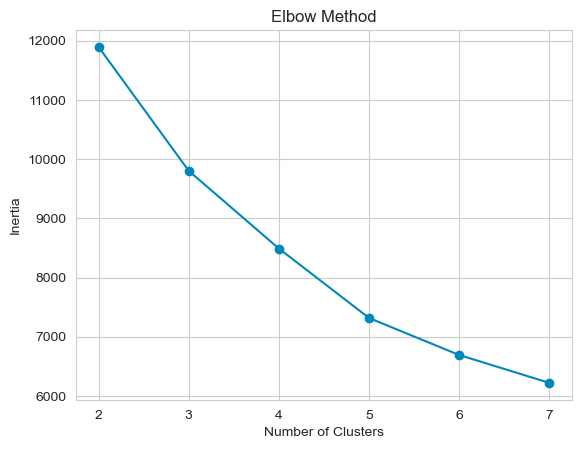

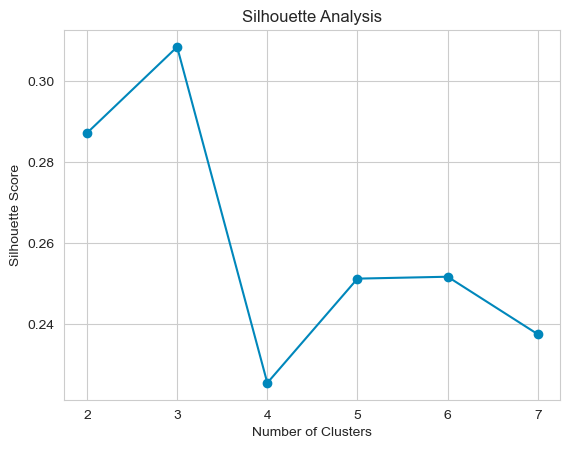

In [121]:
inertia = []
sil_scores = []

K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))


# Plotting Elbow
plt.figure()
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Plotting Silhouette
plt.figure()
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

### 4.3 Model Training (K-Means)

In [122]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

### 4.4 Cluster Visualization (PCA)

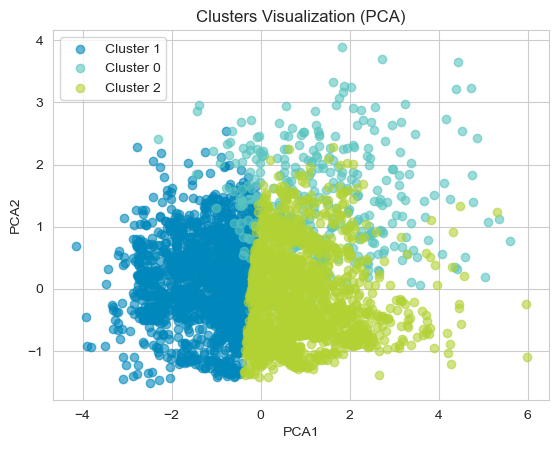

In [123]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_cluster['PCA1'] = X_pca[:, 0]
df_cluster['PCA2'] = X_pca[:, 1]

plt.figure()
for c in df_cluster['cluster'].unique():
    subset = df_cluster[df_cluster['cluster'] == c]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {c}', alpha=0.6)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Clusters Visualization (PCA)")
plt.legend()
plt.show()

fig_3d = px.scatter_3d(df_cluster, 
                    x='sqft_living', 
                    y='price', 
                    z='house_age',
                    color='cluster', # Labels from KMeans
                    title="3D Cluster Separation: Price, Space, and Age",
                    labels={'cluster': 'Market Segment'},
                    opacity=0.7,
                    color_continuous_scale='Viridis')

fig_3d.update_layout(margin=dict(l=0, r=0, b=0, t=40))
fig_3d.show()

### 4.5 Cluster Mapping: Defining Market Segments

In [124]:
df_cluster.groupby('cluster')[cluster_features].mean()
df_cluster.groupby('cluster')[cluster_features].mean()

,sqft_living_log,bedrooms,bathrooms,view,waterfront,condition,house_age
cluster,,,,,,,
0,7.990978,3.850440,2.767595,2.668622,0.079179,3.583578,47.108504
1,7.222535,2.800107,1.474746,0.055051,0.000534,3.577766,59.904864
2,7.791966,3.804721,2.605794,0.016738,0.000000,3.327897,29.256223


In [125]:
cluster_map = {
    2: 'Mid-Market / Family-Oriented Homes',
    1: 'Entry-Level / Affordable Urban Homes',
    0: 'Premium / Luxury Homes'
}
df_cluster['market_segment'] = df_cluster['cluster'].map(cluster_map)

In [126]:
df_cluster['market_segment'].value_counts()

market_segment
Mid-Market / Family-Oriented Homes      2330
Entry-Level / Affordable Urban Homes    1871
Premium / Luxury Homes                   341
Name: count, dtype: int64

## 5. Category Classification

In [127]:
df_classification = df_cluster.copy()
df_classification.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4542 entries, 0 to 4599
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             4542 non-null   datetime64[ns]
 1   price            4542 non-null   float64       
 2   bedrooms         4542 non-null   float64       
 3   bathrooms        4542 non-null   float64       
 4   sqft_living      4542 non-null   int64         
 5   sqft_lot         4542 non-null   int64         
 6   floors           4542 non-null   float64       
 7   waterfront       4542 non-null   int64         
 8   view             4542 non-null   int64         
 9   condition        4542 non-null   int64         
 10  sqft_above       4542 non-null   int64         
 11  sqft_basement    4542 non-null   int64         
 12  yr_built         4542 non-null   datetime64[ns]
 13  yr_renovated     1839 non-null   datetime64[ns]
 14  city             4542 non-null   object      

In [128]:
city_freq = df_classification['city'].value_counts(normalize=True)
df_classification['city_freq'] = df_classification['city'].map(city_freq)

In [129]:
features = [
    'bedrooms', 'bathrooms',
    'sqft_living', 'sqft_lot',
    'floors', 'waterfront',
    'view', 'condition',
    'sqft_above', 'sqft_basement',
    'house_age', 'city_freq'
]

X = df_classification[features]
y = df_classification['cluster']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train-Test Split:")
print(f"   - Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   - Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   - Train class distribution: {np.bincount(y_train)}")
print(f"   - Test class distribution: {np.bincount(y_test)}")

Train-Test Split:
   - Train: 3633 samples (80.0%)
   - Test: 909 samples (20.0%)
   - Train class distribution: [ 273 1496 1864]
   - Test class distribution: [ 68 375 466]


In [131]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Used RobustScaler (resistant to outliers)")

Used RobustScaler (resistant to outliers)


In [132]:
logistic_reg = LogisticRegression(
    penalty='l2',
    C=3.0,
    random_state=42,
    max_iter=10
)
logistic_reg.fit(X_train_scaled, y_train)
y_pred = logistic_reg.predict(X_test_scaled)
print("Accuracy:", logistic_reg.score(X_test_scaled, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Mid-Market', 'Entry-Level', 'Premium']))


Accuracy: 0.966996699669967
Confusion Matrix:
 [[ 66   2   0]
 [  1 364  10]
 [  6  11 449]]
              precision    recall  f1-score   support

  Mid-Market       0.90      0.97      0.94        68
 Entry-Level       0.97      0.97      0.97       375
     Premium       0.98      0.96      0.97       466

    accuracy                           0.97       909
   macro avg       0.95      0.97      0.96       909
weighted avg       0.97      0.97      0.97       909



In [133]:
grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=10),
    param_grid={
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['saga', 'liblinear'],
        'max_iter': [10, 50, 100, 200]
    },
    scoring='f1_macro',  # Use macro average for multiclass
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_scaled, y_train)
print("Best Hyperparameters:", grid.best_params_)
y_pred = grid.predict(X_test_scaled)
print("Accuracy:", grid.score(X_test_scaled, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Mid-Market', 'Entry-Level', 'Premium']))

Fitting 5 folds for each of 160 candidates, totalling 800 fits


Best Hyperparameters: {'C': 100.0, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.9777727397411281
Confusion Matrix:
 [[ 68   0   0]
 [  2 370   3]
 [  5   1 460]]
              precision    recall  f1-score   support

  Mid-Market       0.91      1.00      0.95        68
 Entry-Level       1.00      0.99      0.99       375
     Premium       0.99      0.99      0.99       466

    accuracy                           0.99       909
   macro avg       0.97      0.99      0.98       909
weighted avg       0.99      0.99      0.99       909



In [134]:
random_forest = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    criterion='entropy',
    min_samples_split=10,
    min_samples_leaf=3,
    max_features='sqrt'
)
random_forest.fit(X_train_scaled, y_train)
y_pred = random_forest.predict(X_test_scaled)
print("Accuracy:", random_forest.score(X_test_scaled, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Mid-Market', 'Entry-Level', 'Premium']))

Accuracy: 0.9691969196919692
Confusion Matrix:
 [[ 66   2   0]
 [  0 362  13]
 [  0  13 453]]
              precision    recall  f1-score   support

  Mid-Market       1.00      0.97      0.99        68
 Entry-Level       0.96      0.97      0.96       375
     Premium       0.97      0.97      0.97       466

    accuracy                           0.97       909
   macro avg       0.98      0.97      0.97       909
weighted avg       0.97      0.97      0.97       909



In [135]:
xgb_model = XGBClassifier(
    n_estimators=None,
    max_depth=6,
    learning_rate=0.25,
    subsample=0.8,
    colsample_bytree=0.5,
    scale_pos_weight=1,
    random_state=42,
)
xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)
print("Accuracy:", xgb_model.score(X_test_scaled, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Mid-Market', 'Entry-Level', 'Premium']))

Accuracy: 0.9856985698569857
Confusion Matrix:
 [[ 67   1   0]
 [  1 369   5]
 [  0   6 460]]
              precision    recall  f1-score   support

  Mid-Market       0.99      0.99      0.99        68
 Entry-Level       0.98      0.98      0.98       375
     Premium       0.99      0.99      0.99       466

    accuracy                           0.99       909
   macro avg       0.99      0.99      0.99       909
weighted avg       0.99      0.99      0.99       909



## 6. Regression

In [136]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np


In [137]:
features = [
    'bedrooms', 'bathrooms',
    'sqft_living', 'sqft_lot',
    'floors', 'waterfront',
    'view', 'condition',
    'sqft_above', 'sqft_basement',
    'house_age', 'city_freq'
]

target = 'price_log'

In [138]:

from sklearn.model_selection import GridSearchCV

# 1. Filter Cluster 1
df_c0 = df_classification[df_classification['cluster'] == 0].copy()

q_low = df_c0["price_log"].quantile(0.10)
q_hi  = df_c0["price_log"].quantile(0.90)
df_c0_filtered = df_c0[(df_c0["price_log"] < q_hi) & (df_c0["price_log"] > q_low)]
X_c0 = df_c0_filtered[features]
y_c0 = df_c0_filtered[target]

X_train_c0, X_test_c0, y_train_c0, y_test_c0 = train_test_split(
    X_c0, y_c0, test_size=0.2, random_state=42
)

# 3. Dedicated XGBoost with Higher Regularization
xgb_c0 = XGBRegressor(
     n_estimators=500,
            max_depth=10,
            learning_rate=0.03,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=1.0,         # L1 Regularization
            reg_lambda=10.0,       # L2 Regularization
            random_state=42
)

xgb_c0.fit(X_train_c0, y_train_c0)
y_pred_c0 = xgb_c0.predict(X_test_c0)
new_mae_log = mean_absolute_error(y_test_c0, y_pred_c0)
print(f"Improved Cluster 0 MAE (log): {new_mae_log:.4f}")

Improved Cluster 0 MAE (log): 0.2592


In [139]:
X_test_full = df_c0[features]
y_test_full = df_c0[target]

y_pred_full = xgb_c0.predict(X_test_full)

mae_full = mean_absolute_error(y_test_full, y_pred_full)
mae_full

0.25483913340411735

In [140]:

# 1. Filter Cluster 1
df_c1 = df_classification[df_classification['cluster'] == 1].copy()

q_low = df_c1["price_log"].quantile(0.05)
q_hi  = df_c1["price_log"].quantile(0.95)
df_c1_filtered = df_c1[(df_c1["price_log"] < q_hi) & (df_c1["price_log"] > q_low)]
X_c1 = df_c1_filtered[features]
y_c1 = df_c1_filtered[target]

X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(
    X_c1, y_c1, test_size=0.2, random_state=42
)

# 3. Dedicated XGBoost with Higher Regularization
xgb_c1 = XGBRegressor(
     n_estimators=500,
            max_depth=5,
            learning_rate=0.03,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=1.0,         # L1 Regularization
            reg_lambda=10.0,       # L2 Regularization
            random_state=42
)

xgb_c1.fit(X_train_c1, y_train_c1)
y_pred_c1 = xgb_c1.predict(X_test_c1)
new_mae_log = mean_absolute_error(y_test_c1, y_pred_c1)
print(f"Improved Cluster 1 MAE (log): {new_mae_log:.4f}")

Improved Cluster 1 MAE (log): 0.1864


In [141]:
X_test_full = df_c1[features]
y_test_full = df_c1[target]

y_pred_full = xgb_c1.predict(X_test_full)

mae_full = mean_absolute_error(y_test_full, y_pred_full)
mae_full

0.1857878760512803

In [142]:

from sklearn.model_selection import GridSearchCV

# 1. Filter Cluster 2
df_c2 = df_classification[df_classification['cluster'] == 2].copy()

q_low = df_c2["price_log"].quantile(0.05)
q_hi  = df_c2["price_log"].quantile(0.95)
df_c2_filtered = df_c2[(df_c2["price_log"] < q_hi) & (df_c2["price_log"] > q_low)]

X_c2 = df_c2_filtered[features]
y_c2 = df_c2_filtered[target]

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X_c2, y_c2, test_size=0.2, random_state=42
)

# 3. Dedicated XGBoost with Higher Regularization
xgb_c2 = XGBRegressor(
     n_estimators=500,
            max_depth=5,
            learning_rate=0.03,
            subsample=0.7,
            colsample_bytree=0.7,
            reg_alpha=1.0,         # L1 Regularization
            reg_lambda=10.0,       # L2 Regularization
            random_state=42
)

xgb_c2.fit(X_train_c2, y_train_c2)
y_pred_c2 = xgb_c2.predict(X_test_c2)

new_mae_log = mean_absolute_error(y_test_c2, y_pred_c2)
print(f"Improved Cluster 2 MAE (log): {new_mae_log:.4f}")

Improved Cluster 2 MAE (log): 0.1304


In [143]:
X_test_full = df_c2[features]
y_test_full = df_c2[target]

y_pred_full = xgb_c2.predict(X_test_full)

mae_full = mean_absolute_error(y_test_full, y_pred_full)
mae_full


0.1559707272607824

In [144]:
df_classification.to_csv('data/house_data_classification.csv', index=False)

## 7. LLM-based Model Interpretation

In [145]:
import pandas as pd
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors

# --- 1. Comprehensive Real-World Knowledge Base for All 44 Cities ---
# معلومات موثقة ومخصصة لكل مدينة في واشنطن لضمان الـ 132 سيناريو
CITY_KNOWLEDGE = {
    'Seattle': "The global tech hub, home to Amazon and Starbucks, offering vibrant urban culture and diverse neighborhoods.",
    'Bellevue': "Known for its high-end shopping, top-tier schools, and as a secondary major tech hub with a polished suburban feel.",
    'Kent': "A vital logistical and industrial center, offering great parks and a more affordable, diverse community living.",
    'Medina': "One of the most exclusive enclaves in the US, home to tech titans, offering ultimate privacy and luxury.",
    'Redmond': "The 'Bicycle Capital of the Northwest' and headquarters of Microsoft, blending tech innovation with nature.",
    'Mercer Island': "An exclusive island community offering high-end waterfront living and some of the best schools in the state.",
    'Kirkland': "A trendy waterfront city known for its downtown beaches, art galleries, and upscale dining.",
    'Issaquah': "Nestled in the 'Issaquah Alps', perfect for outdoor enthusiasts who want a mix of nature and modern amenities.",
    'Shoreline': "A quiet residential gem with a coastal feel, known for its excellent school district and great transit access.",
    'Renton': "A historic hub for Boeing, now a fast-growing city with a revitalized waterfront and diverse housing.",
    'Sammamish': "Consistently ranked as one of the best places to live for families, known for its safety and greenery.",
    'Federal Way': "Home to Wild Waves and Dash Point Park, offering a coastal suburban lifestyle with great accessibility.",
    'Woodinville': "The heart of Washington's wine country, offering a mix of rural charm and high-end estates.",
    'Auburn': "A valley city with a rich equestrian history, home to the Muckleshoot Casino and the SuperMall.",
    'Maple Valley': "A top choice for families seeking highly-rated schools and a quiet, semi-rural lifestyle with modern parks.",
    'North Bend': "A gateway to mountain adventures at the foot of Mount Si, famous for its scenic beauty and 'Twin Peaks' charm.",
    'Lake Forest Park': "A densely wooded residential area known for its nature preserves and community-focused living near Lake Washington.",
    'Des Moines': "A beautiful coastal city with a popular marina, waterfront parks, and stunning views of the Puget Sound.",
    'Bothell': "A fast-developing hub with a revitalized downtown, balancing a booming bio-tech industry with historic roots.",
    'Normandy Park': "An elegant, secluded community offering private beach access and high-end coastal residential estates.",
    'Fall City': "A picturesque rural community at the junction of rivers, offering a peaceful lifestyle surrounded by nature.",
    'Carnation': "The agricultural heart of the valley, known for its organic farms, rivers, and tranquil rural atmosphere.",
    'Snoqualmie': "Home to the world-famous Snoqualmie Falls, combining historic charm with upscale modern developments.",
    'Duvall': "A charming small town with a strong arts scene and a focus on preserving its natural and historic character.",
    'Burien': "A trendy, diverse community with a thriving culinary scene and a rapidly developing downtown area.",
    'Covington': "A major retail and commercial hub providing modern suburban conveniences and family-oriented neighborhoods.",
    'Inglewood-Finn Hill': "A highly desirable residential area within Kirkland, known for its lush parks and excellent school access.",
    'Kenmore': "Known as the 'Seaplane Capital', sitting at the north end of Lake Washington with a focus on aviation and tech.",
    'Newcastle': "An upscale community famous for its premier golf club and breathtaking views of the Seattle skyline.",
    'Black Diamond': "A historic mining town now evolving into a major residential area with stunning views of Mt. Rainier.",
    'Ravensdale': "A quiet, forested retreat offering large lot sizes and deep immersion in the natural beauty of the Northwest.",
    'Clyde Hill': "An ultra-luxury hilltop community offering some of the most spectacular views of Lake Washington and Seattle.",
    'Algona': "A tight-knit, friendly residential community focusing on local parks and housing affordability.",
    'Skykomish': "A historic mountain town serving as a gateway to Stevens Pass, perfect for outdoor sports and cabin living.",
    'Tukwila': "A commercial powerhouse and transit hub, home to the Southcenter Mall and major logistical centers.",
    'Vashon': "A unique island community accessible by ferry, known for its artistic soul, local farms, and coastal serenity.",
    'Yarrow Point': "An elite waterfront peninsula with high-value estates and a quiet, prestigious residential atmosphere.",
    'SeaTac': "The region's primary transit hub, offering unparalleled global accessibility and a growing hospitality sector.",
    'Enumclaw': "Known as the 'Gateway to Mt. Rainier', it offers a beautiful plateau setting with strong agricultural roots.",
    'Snoqualmie Pass': "The premier mountain destination for year-round recreation, from skiing in winter to hiking in summer.",
    'Pacific': "A small-town atmosphere on the valley floor, offering affordable living and a sense of community.",
    'Beaux Arts Village': "A historic and artistic enclave with private beach rights and a focus on preserving its unique heritage.",
    'Preston': "A forested gateway to the mountains, home to local industries and large, private residential estates.",
    'Milton': "A peaceful suburban community offering a mix of established neighborhoods and newer residential growth."
}

DEFAULT_CITY_DESC = "A well-established community in King County offering a unique blend of Northwest living and accessibility."

# --- 2. Narrative Templates for Clusters ---
CLUSTER_NARRATIVES = {
    0: { # Premium / Luxury
        "title": "Elite Investment / Luxury Living",
        "description": "This property represents the pinnacle of the market. Investing here means securing a trophy asset that prioritizes exclusivity, architectural excellence, and superior location value."
    },
    1: { # Entry-Level / Affordable
        "title": "Smart Market Entry / High Value",
        "description": "An ideal opportunity for first-time buyers or savvy investors. This segment focuses on functional urban living and provides an accessible entry point into the competitive Washington market."
    },
    2: { # Mid-Market / Family
        "title": "Strategic Family Choice / Balanced Living",
        "description": "Located in the 'sweet spot' of the market, this home offers the perfect balance between spacious accommodation and sustainable long-term value for growing families."
    }
}

def property_to_text_smart(row):
    """
    Generating 132 unique paths (44 Cities x 3 Clusters).
    Includes: Zip Code, Price/Sqft, Sqft Above, View, Lot, Floors, and Basement.
    """
    city_name = row['city']
    cluster_id = int(row['cluster'])
    zip_code = row['statezip']
    
    # Selecting the specific city fact (1 of 44)
    city_fact = CITY_KNOWLEDGE.get(city_name, DEFAULT_CITY_DESC)
    
    # Selecting the specific cluster narrative (1 of 3)
    cluster_info = CLUSTER_NARRATIVES.get(cluster_id, CLUSTER_NARRATIVES[2])
    
    # Financial Logic
    price_per_sqft = row['price'] / row['sqft_living'] if row['sqft_living'] > 0 else 0

    # Physical Feature Logic
    view_desc = ""
    if row['view'] >= 3:
        view_desc = " featuring an exceptional panoramic view that commands a significant market premium."
    elif row['view'] > 0:
        view_desc = " offering a pleasant local view that enhances the daily living experience."

    basement_info = f" and a functional lower-level basement of {row['sqft_basement']:,} sqft," if row['sqft_basement'] > 0 else ","
    floor_info = "single-level" if row['floors'] == 1 else f"{row['floors']}-story"

    # Creating the final narrative (The result of one of the 132 paths)
    text = f"""
    <b>Location Profile:</b> {city_name} ({zip_code}) is {city_fact}<br/><br/>
    
    <b>Market Positioning:</b> This property is classified under the <b>{cluster_info['title']}</b> segment. 
    {cluster_info['description']}<br/><br/>
    
    <b>Physical Attributes:</b> This {floor_info} residence offers a total living area of {row['sqft_living']:,} sqft. 
    The layout includes {row['sqft_above']:,} sqft of main-level living space{basement_info} featuring {int(row['bedrooms'])} bedrooms 
    and {row['bathrooms']} bathrooms. The home is situated on a {row['sqft_lot']:,} sqft lot{view_desc}. 
    Built in {row['yr_built'].year if hasattr(row['yr_built'], 'year') else row['yr_built']}, 
    this {row['house_age']}-year-old home is maintained in a '{row['condition']}/5' condition.
    """

    if pd.notna(row['yr_renovated']) and str(row['yr_renovated']) != '0':
        text += f" A significant renovation in {row['yr_renovated'].year if hasattr(row['yr_renovated'], 'year') else row['yr_renovated']} ensures modern interior standards and protects capital value."

    if row['waterfront'] == 1:
        text += " Its rare waterfront position provides an irreplaceable lifestyle 'premium' and long-term asset security."

    text += f"""<br/><br/>
    <b>Financial Verdict:</b> At a listing price of ${row['price']:,.0f}, this translates to approximately 
    <b>${price_per_sqft:,.2f} per square foot</b>. Our AI analytics verify this valuation as highly 
    consistent for the <b>{row['market_segment']}</b> within the {zip_code} micro-market.
    """

    return text.strip()

def generate_enhanced_pdf(df, output_path):
    styles = getSampleStyleSheet()
    styles["Normal"].leading = 14
    styles["Normal"].fontSize = 11

    doc = SimpleDocTemplate(
        output_path,
        pagesize=A4,
        rightMargin=50, leftMargin=50, topMargin=50, bottomMargin=50
    )

    story = []
    # Main Document Header
    story.append(Paragraph("<b>Real Estate Machine: Smart Investment Report</b>", styles["Title"]))
    story.append(Spacer(1, 24))

    for i, row in df.iterrows():
        # Individual Property Header
        story.append(Paragraph(f"Analysis for Property ID: {i} - {row['city']} ({row['statezip']})", styles["Heading2"]))
        story.append(Spacer(1, 10))
        
        # Calling the smart engine
        narrative = property_to_text_smart(row)
        story.append(Paragraph(narrative, styles["Normal"]))
        
        story.append(Spacer(1, 10))
        story.append(Paragraph("<hr color='grey' width='100%'/>", styles["Normal"]))
        story.append(Spacer(1, 25))

    doc.build(story)

# Usage Example:
generate_enhanced_pdf(df_classification, "data/smart_real_estate_report.pdf")

In [146]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import fitz  # PyMuPDF
import torch
import textwrap
# https://huggingface.co/google/flan-t5-base
# Load FLAN-T5 model and tokenizer
model_name = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# ---------------------- PDF Reader ----------------------
def read_pdf_text(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

# ---------------------- Chunk Splitter ----------------------
def split_into_chunks(text, max_words=200):
    words = text.split()
    return [' '.join(words[i:i+max_words]) for i in range(0, len(words), max_words)]


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [147]:
# ---------------------- QA Function ----------------------
def ask_question_flan(question, context_chunks):
    best_answer = ""
    best_score = float("-inf")

    for chunk in context_chunks:
        prompt = f"answer the question based on the context:\ncontext: {chunk}\nquestion: {question}"
        input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).input_ids.to(device)

        outputs = model.generate(input_ids, max_length=100)
        answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Simple heuristic: prefer longer answers with more content
        score = len(answer.strip().split())
        if score > best_score:
            best_answer = answer
            best_score = score

    return best_answer.strip()

In [149]:
# pdf_path = "data\smart_real_estate_report.pdf"
# print(" Reading PDF...")
# text = read_pdf_text(pdf_path)

# print(" Splitting text...")
# chunks = split_into_chunks(text)

# question = input(" Ask your question: ")
# print("🤖 Thinking...")

# answer = ask_question_flan(question, chunks)

# print("\n✅ Answer:")
# print(textwrap.fill(answer, width=80))


In [ ]:
# import requests

# GROQ_API_KEY = "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" 
# url = "https://api.groq.com/openai/v1/chat/completions"

# headers = {
#     "Authorization": f"Bearer {GROQ_API_KEY}",
#     "Content-Type": "application/json"
# }
# content = """
#   You are a Washington real estate sales consultant.
#     ALL properties you discuss MUST come directly from internal data.
#     Generic marketing language is forbidden.
#     LANGUAGE RULE (MANDATORY):
#     - If the user writes in Arabic, you MUST respond in clear Egyptian Arabic.
#     - If the user writes in English, respond in professional English.
#     Your job is to show real properties, compare them numerically, and explain prices using clear, concrete trade-offs.
#     Every price discussion MUST include at least one explicit trade-off linked to real data.
#     You MUST connect price to: bedrooms, sqft_living, city demand, cluster similarity.
#     Forbidden words: beautiful, premium, competitive, unique, desirable, might, could, usually, generally.
#     Response rules: Max 4-5 short sentences. No storytelling. No emotional language.
#     Always end with a clear choice framed as a trade-off.

# """
# chat_history = [
#     {"role": "system", "content": content}
# ]

# while True:
#     user_input = input("🧑 You: ")
#     if user_input.lower() == "exit":
#         print("👋 Goodbye!")
#         break

#     chat_history.append({"role": "user", "content": user_input})

#     data = {
#         "model": "llama-3.3-70b-versatile",
#         "messages": chat_history,
#         "temperature": 0.7
#     }

#     response = requests.post(url, headers=headers, json=data)

#     if response.status_code == 200:
#         reply = response.json()["choices"][0]["message"]["content"]
#         chat_history.append({"role": "assistant", "content": reply})
#         print(f"🤖 Bot: {reply}\n")
#     else:
#         print(f"[Error] {response.status_code}: {response.text}")


## 8. Deployment

In [79]:
import joblib
import json
import os

# --- 1. Create a directory for models if it doesn't exist ---
if not os.path.exists('models'):
    os.makedirs('models')

# --- 2. Export the Preprocessing Scaler ---
# Essential to transform new user input using the same scale as training data
joblib.dump(scaler, 'models/robust_scaler.pkl')

# --- 3. Export the Classification Model (Market Segment Predictor) ---
# This identifies whether the property is Premium, Economic, or Mid-Market
joblib.dump(xgb_model, 'models/classifier_market_segment.pkl')

# --- 4. Export the Regression Models (Price Predictors) ---
# We save each cluster's model from our 'regression_models' dictionary
joblib.dump(xgb_c0, 'models/regressor_cluster_0_premium.pkl')
joblib.dump(xgb_c1, 'models/regressor_cluster_1_economic.pkl')
joblib.dump(xgb_c2, 'models/regressor_cluster_2_family.pkl')

# --- 5. Export Mappings and Encodings ---
# Save the Zip Code average price map for the 'zip_mean_price' feature
# Create the zip_map from your training data
zip_map = df_classification.groupby('statezip')['price_log'].mean().to_dict()
with open('data/zip_code_map.json', 'w') as f:
    json.dump(zip_map, f)

# Save the human-readable market segment names
cluster_map = {
    0: 'Premium / Luxury Homes',
    1: 'Entry-Level / Affordable Urban Homes',
    2: 'Mid-Market / Family-Oriented Homes'
}
with open('models/cluster_mapping.json', 'w') as f:
    json.dump(cluster_map, f)

# --- 6. Export the Final Engineered Features List ---
# To ensure the Inference script uses the exact same feature order
joblib.dump(features, 'models/features_list.pkl')

print("✅ All project components exported successfully to /models directory.")

✅ All project components exported successfully to /models directory.
